In [55]:
#Mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [56]:
#import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
import time
import random
import warnings
warnings.filterwarnings("ignore")
# Always good to set a seed for reproducibility
SEED = 7
np.random.seed(SEED)

from IPython.display import display
%matplotlib inline

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)

from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier


In [57]:
# get working directory and files
os.getcwd()
path='/content/gdrive/My Drive/Mortgage default prediction/data_export'
os.listdir(path)

['current.csv',
 'default.csv',
 'prepaid.csv',
 'Untitled spreadsheet.gsheet',
 'Unemployment Rate.csv',
 'FedFundsRate_AvgYield_State.csv',
 'T10Y3M (1).csv',
 'MedianIncomePerCapita.csv',
 'HPI_State.csv',
 'FedFundsRate_AvgYield_State.gsheet',
 'divorce_rates.csv',
 'df_equal.csv',
 'df_unequal.csv',
 'df_equal.gsheet']

In [58]:
def get_mortgage_data(base_dir):
  os.listdir(base_dir)
  df_c=pd.read_csv(os.path.join(path, "current.csv"))
  df_d=pd.read_csv(os.path.join(path, "default.csv"))
  df_p=pd.read_csv(os.path.join(path, "prepaid.csv"))
  df_u=pd.read_csv(os.path.join(path, "Unemployment Rate.csv"))
  df_h=pd.read_csv(os.path.join(path, "HPI_State.csv"))
  df_i=pd.read_csv(os.path.join(path, "MedianIncomePerCapita.csv"))
  df_dr=pd.read_csv(os.path.join(path, "divorce_rates.csv"))
  return df_c, df_d, df_p,df_u,df_h,df_i,df_dr


In [59]:
base_dir='/content/gdrive/My Drive/Mortgage default prediction/data_export'
df_current,df_default,df_prepaid,df_unply,df_hindex,df_income,df_divorce=get_mortgage_data(base_dir)

In [60]:
# Process each loan dataframe (default,prepaid,currnet)
# Default
default_feat=list(df_default.columns)
default_feat
feat=['LOAN_ID','ORIG_RT','ORIG_AMT','F90_DTE','LOAN_AGE','LAST_STAT','OLTV','OCLTV','FTHB_FLG',
      'DTI','CSCORE_B','NUM_BO','PURPOSE','PROP_TYP','NUM_UNIT','OCC_STAT','STATE','ZIP_3','CSCORE_C','ORIG_VAL','VinYr','ActYr','FicoBkt']
df_default_new=df_default[feat]
df_default_new.head()

# Current
df_current['F90_DTE']=""
df_current['LOAN_AGE']=(df_current['ActYr']-df_current['VinYr'])*12
df_current_new=df_current[feat]
df_current_new.head()

# Prepaid
df_prepaid['F90_DTE']=""
df_prepaid['LOAN_AGE']=(df_prepaid['ActYr']-df_prepaid['VinYr'])*12
df_prepaid_new=df_prepaid[feat]
df_prepaid_new.head()

#concatenate dataframes
frames=[df_default_new,df_current_new,df_prepaid_new]
df_mortgage=pd.concat(frames)
df_mortgage.head()


,LOAN_ID,ORIG_RT,ORIG_AMT,F90_DTE,LOAN_AGE,LAST_STAT,OLTV,OCLTV,FTHB_FLG,DTI,CSCORE_B,NUM_BO,PURPOSE,PROP_TYP,NUM_UNIT,OCC_STAT,STATE,ZIP_3,CSCORE_C,ORIG_VAL,VinYr,ActYr,FicoBkt
0,1.040840e+11,3.125,132000,2/1/14,15,1,66,66,N,41.0,765.0,1,R,SF,1,P,NC,287,NaN,2.000000e+05,2012,2020,[740-780)
1,1.412390e+11,3.750,160000,2/1/14,14,1,71,71,N,50.0,786.0,1,C,SF,1,P,PR,6,NaN,2.253521e+05,2012,2020,[780+)
2,1.612170e+11,3.875,84000,9/1/13,10,1,80,80,N,36.0,741.0,2,P,SF,1,I,PA,161,770.0,1.050000e+05,2012,2020,[740-780)
3,1.779820e+11,3.990,344000,7/1/13,8,1,95,95,N,35.0,668.0,1,P,SF,1,P,TX,787,NaN,3.621053e+05,2012,2020,[660-700)
4,1.862940e+11,3.625,522000,11/1/14,22,1,48,79,N,45.0,720.0,2,R,SF,2,P,NY,112,699.0,1.087500e+06,2013,2020,[660-700)


In [61]:
#drop current and prepaid loans that originated in 2012
df_mortgage=df_mortgage[df_mortgage.VinYr>2012]

In [62]:
# Function for adding external data
def add_external(df1,df2,feature):
  df=[]
  for i in range(2013,2019,1):
    df1_y=df1[df1.VinYr==i]
    df2_y=df2[['Abb',str(i)]]
    df_join=pd.merge(left=df1_y,right=df2_y,left_on='STATE', right_on='Abb')
    df_join[feature]=df_join[str(i)]
    df_join.drop([str(i),'Abb'],axis=1,inplace=True)
    df.append(df_join)
  df=pd.concat(df)
  return df

df_unemployment=add_external(df_mortgage,df_unply,'Unemployment')
df_house_index=add_external(df_mortgage,df_hindex,'House_price_Index')
df_cap_income=add_external(df_mortgage,df_income,'Median_Income')
df_divorce_rate=add_external(df_mortgage,df_divorce,'Divorce rate')

In [63]:
# Add external variables to mortgage data
df_merge=pd.merge(left=df_mortgage,right=df_unemployment[['LOAN_ID','Unemployment']],left_on='LOAN_ID', right_on='LOAN_ID')
df_merge=pd.merge(left=df_merge,right=df_house_index[['LOAN_ID','House_price_Index']],left_on='LOAN_ID', right_on='LOAN_ID')
df_merge=pd.merge(left=df_merge,right=df_cap_income[['LOAN_ID','Median_Income']],left_on='LOAN_ID', right_on='LOAN_ID')
df_merge=pd.merge(left=df_merge,right=df_divorce_rate[['LOAN_ID','Divorce rate']],left_on='LOAN_ID', right_on='LOAN_ID')
df_merge.head()

#Generate dataframe for federal funds rate variable
df_fed_rate=pd.DataFrame({'Year':[2013,2014,2015,2016,2017,2018],'Federal_funds_rate':[0.11, 0.09,	0.13,	0.39,	1.00,	1.79]})
df_fed_rate.head()
#Add funds rate
df_merge=pd.merge(left=df_merge,right=df_fed_rate,left_on='VinYr', right_on='Year')

In [64]:
df_merge.head()

,LOAN_ID,ORIG_RT,ORIG_AMT,F90_DTE,LOAN_AGE,LAST_STAT,OLTV,OCLTV,FTHB_FLG,DTI,CSCORE_B,NUM_BO,PURPOSE,PROP_TYP,NUM_UNIT,OCC_STAT,STATE,ZIP_3,CSCORE_C,ORIG_VAL,VinYr,ActYr,FicoBkt,Unemployment,House_price_Index,Median_Income,Divorce rate,Year,Federal_funds_rate
0,1.862940e+11,3.625,522000,11/1/14,22,1,48,79,N,45.0,720.0,2,R,SF,2,P,NY,112,699.0,1.087500e+06,2013,2020,[660-700),7.7,580.60,"49,966",2.7,2013,0.11
1,2.152330e+11,2.750,200000,12/1/14,23,1,61,61,Y,33.0,735.0,1,P,CO,1,P,NJ,76,NaN,3.278689e+05,2013,2020,[700-740),8.2,627.48,"63,754",2.8,2013,0.11
2,2.207550e+11,3.375,185000,11/1/14,22,1,95,95,N,44.0,775.0,1,P,PU,1,P,GA,300,NaN,1.947368e+05,2013,2020,[740-780),8.2,305.07,"46,992",3.4,2013,0.11
3,2.528620e+11,4.375,149000,1/1/15,24,1,85,85,N,44.0,669.0,1,P,PU,1,P,GA,306,NaN,1.752941e+05,2013,2020,[660-700),8.2,305.07,"46,992",3.4,2013,0.11
4,3.350500e+11,4.250,132000,7/1/14,18,1,80,80,N,45.0,647.0,1,P,SF,1,P,FL,320,NaN,1.650000e+05,2013,2020,[620-660),7.2,359.66,"48,532",4.1,2013,0.11


In [65]:
#drop redundant columns
df_merge.drop(columns=['Year'],axis=1,inplace=True)

In [66]:
#rename columns to lower case
df_merge.columns=df_merge.columns.str.lower()
df_merge.columns=df_merge.columns.str.capitalize()
df_merge.head()

,Loan_id,Orig_rt,Orig_amt,F90_dte,Loan_age,Last_stat,Oltv,Ocltv,Fthb_flg,Dti,Cscore_b,Num_bo,Purpose,Prop_typ,Num_unit,Occ_stat,State,Zip_3,Cscore_c,Orig_val,Vinyr,Actyr,Ficobkt,Unemployment,House_price_index,Median_income,Divorce rate,Federal_funds_rate
0,1.862940e+11,3.625,522000,11/1/14,22,1,48,79,N,45.0,720.0,2,R,SF,2,P,NY,112,699.0,1.087500e+06,2013,2020,[660-700),7.7,580.60,"49,966",2.7,0.11
1,2.152330e+11,2.750,200000,12/1/14,23,1,61,61,Y,33.0,735.0,1,P,CO,1,P,NJ,76,NaN,3.278689e+05,2013,2020,[700-740),8.2,627.48,"63,754",2.8,0.11
2,2.207550e+11,3.375,185000,11/1/14,22,1,95,95,N,44.0,775.0,1,P,PU,1,P,GA,300,NaN,1.947368e+05,2013,2020,[740-780),8.2,305.07,"46,992",3.4,0.11
3,2.528620e+11,4.375,149000,1/1/15,24,1,85,85,N,44.0,669.0,1,P,PU,1,P,GA,306,NaN,1.752941e+05,2013,2020,[660-700),8.2,305.07,"46,992",3.4,0.11
4,3.350500e+11,4.250,132000,7/1/14,18,1,80,80,N,45.0,647.0,1,P,SF,1,P,FL,320,NaN,1.650000e+05,2013,2020,[620-660),7.2,359.66,"48,532",4.1,0.11


In [67]:
# Drop prepaid loans and encode current loans as 0
df_merge=df_merge[df_merge.Last_stat!='P']
df_merge.Last_stat=df_merge.Last_stat.replace(to_replace='C',value=0)

In [68]:
#check for missing values
df_merge.isnull().sum()

Loan_id                   0
Orig_rt                   0
Orig_amt                  0
F90_dte                   0
Loan_age                  0
Last_stat                 0
Oltv                      0
Ocltv                     0
Fthb_flg                  0
Dti                      22
Cscore_b                 90
Num_bo                    0
Purpose                   0
Prop_typ                  0
Num_unit                  0
Occ_stat                  0
State                     0
Zip_3                     0
Cscore_c              59503
Orig_val                  0
Vinyr                     0
Actyr                     0
Ficobkt                   0
Unemployment              0
House_price_index         0
Median_income             0
Divorce rate              0
Federal_funds_rate        0
dtype: int64

In [69]:
# Drop borrower and co-borrower credit score variable
df_merge.drop(columns=['Cscore_c','Cscore_b'],inplace=True)

In [70]:
# Drop loans with missing FICO brackets
df_merge=df_merge[df_merge.Ficobkt!='MissingFICO']

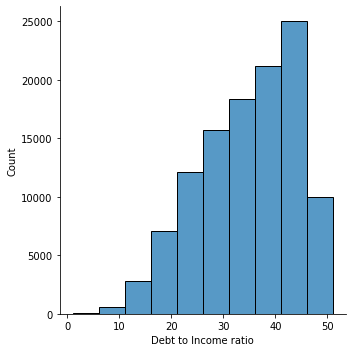

In [71]:
## Treating missing values
#Dti (Debt to income ratio)
sns.displot(df_merge.Dti,binwidth=5)
plt.xlabel("Debt to Income ratio")
#Fill in missing value with mean 
df_merge.Dti=df_merge.Dti.fillna(df_merge.Dti.mean())

In [72]:
#confirnming missing values were filled
df_merge.isnull().sum()

Loan_id               0
Orig_rt               0
Orig_amt              0
F90_dte               0
Loan_age              0
Last_stat             0
Oltv                  0
Ocltv                 0
Fthb_flg              0
Dti                   0
Num_bo                0
Purpose               0
Prop_typ              0
Num_unit              0
Occ_stat              0
State                 0
Zip_3                 0
Orig_val              0
Vinyr                 0
Actyr                 0
Ficobkt               0
Unemployment          0
House_price_index     0
Median_income         0
Divorce rate          0
Federal_funds_rate    0
dtype: int64

In [73]:
df_merge.dtypes

Loan_id               float64
Orig_rt               float64
Orig_amt                int64
F90_dte                object
Loan_age                int64
Last_stat               int64
Oltv                    int64
Ocltv                   int64
Fthb_flg               object
Dti                   float64
Num_bo                  int64
Purpose                object
Prop_typ               object
Num_unit                int64
Occ_stat               object
State                  object
Zip_3                   int64
Orig_val              float64
Vinyr                   int64
Actyr                   int64
Ficobkt                object
Unemployment          float64
House_price_index     float64
Median_income          object
Divorce rate          float64
Federal_funds_rate    float64
dtype: object

No handles with labels found to put in legend.


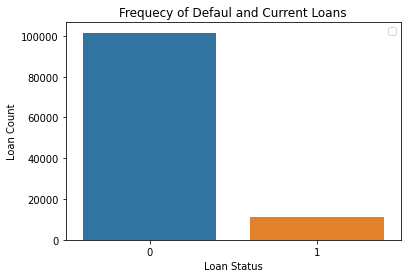

In [74]:
df_merge.Last_stat.value_counts()
sns.countplot(df_merge.Last_stat)
plt.title('Frequecy of Defaul and Current Loans')
plt.ylabel('Loan Count')
plt.xlabel('Loan Status')
plt.legend()

In [75]:
# Convert number of borrowers to a binary variable
df_merge.Num_bo=df_merge['Num_bo'].replace([2,3,4],[0,0,0])

In [76]:
df_merge.Num_bo.value_counts()

1    59354
0    53560
Name: Num_bo, dtype: int64

In [77]:
# strip comma off median income to make it an int
df_merge.Median_income=df_merge.Median_income.apply(lambda x:x.replace(",", ""))
df_merge.Median_income= pd.to_numeric(df_merge.Median_income, errors='coerce')

In [78]:
# Further exploratory Data Analysis for Categorical variables
# Get list of categorical variables
cat=(df_merge.dtypes=='object')
cat_columns=list(cat[cat].index)
print("Categorical variables:")
print(cat_columns)

Categorical variables:
['F90_dte', 'Fthb_flg', 'Purpose', 'Prop_typ', 'Occ_stat', 'State', 'Ficobkt']


In [79]:
def cat_feature_prob(feature,df):
  print(df[[feature,'Last_stat']].groupby([feature],as_index=False).mean())
  sns.catplot(x=feature,col='Last_stat',kind='count', data=df)
  


  Fthb_flg  Last_stat
0        N    0.07709
1        Y    0.17729


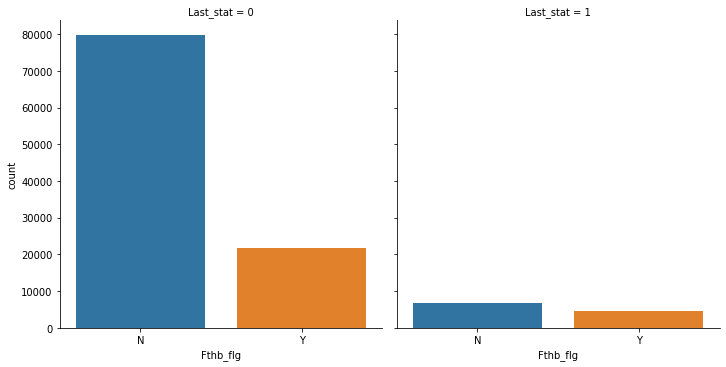

In [80]:
# First time home buyer indicator
cat_feature_prob('Fthb_flg',df_merge)

  Purpose  Last_stat
0       C   0.121009
1       P   0.118386
2       R   0.042112


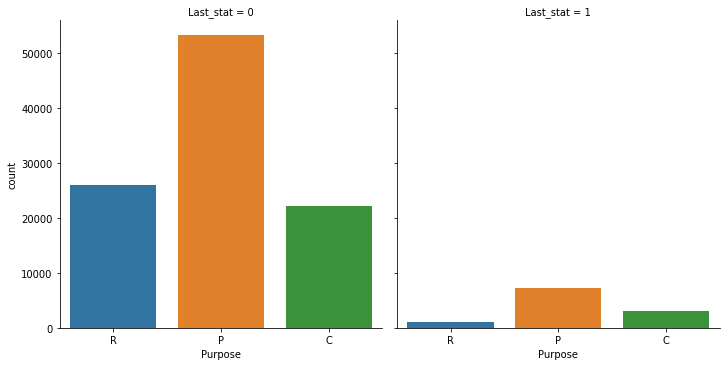

In [81]:
# Purpose of Loan
cat_feature_prob('Purpose',df_merge)

  Prop_typ  Last_stat
0       CO   0.089927
1       CP   0.024955
2       MH   0.131202
3       PU   0.095317
4       SF   0.104408


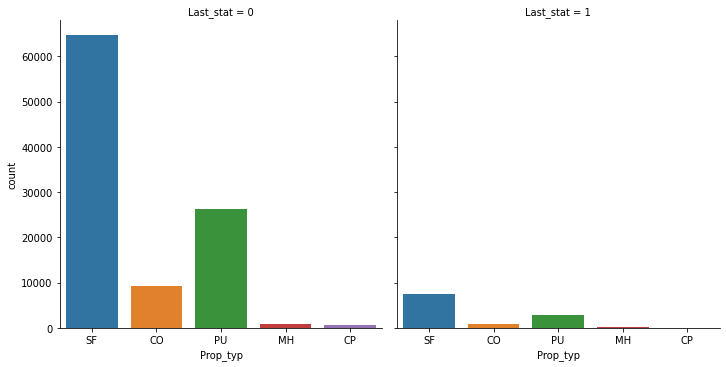

In [82]:
# Property Type
cat_feature_prob('Prop_typ',df_merge)

   Num_bo  Last_stat
0       0   0.053305
1       1   0.143259


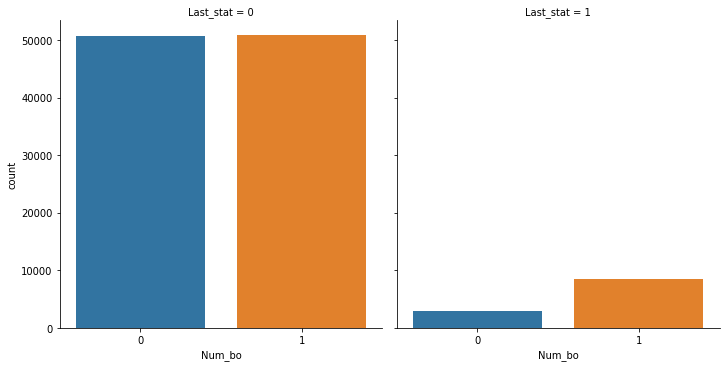

In [83]:
#Number of borrowers
cat_feature_prob('Num_bo',df_merge)

     Ficobkt  Last_stat
0    [0-620)   0.555556
1  [620-660)   0.439856
2  [660-700)   0.247180
3  [700-740)   0.103162
4  [740-780)   0.035482
5     [780+)   0.009817


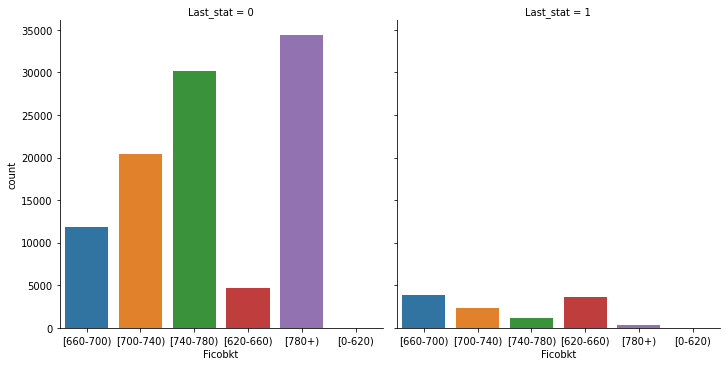

In [84]:
# Credit score bracket
cat_feature_prob('Ficobkt',df_merge)

In [85]:
#Explore Continuous variables
numerical=(df_merge.dtypes!='object')
numerical_cols=list(numerical[numerical].index)
numerical_cols
#drop irrelevent columns


['Loan_id',
 'Orig_rt',
 'Orig_amt',
 'Loan_age',
 'Last_stat',
 'Oltv',
 'Ocltv',
 'Dti',
 'Num_bo',
 'Num_unit',
 'Zip_3',
 'Orig_val',
 'Vinyr',
 'Actyr',
 'Unemployment',
 'House_price_index',
 'Median_income',
 'Divorce rate',
 'Federal_funds_rate']

In [86]:
def hist_boxplot(df,col):
  sns.displot(df[col])
  plt.title('Histogram for {}'.format(col))
  plt.show()
  sns.boxplot(x=df['Last_stat'],y=df[col])
  plt.title('Boxplot for {} against Loan Status'.format(col))
  plt.show()


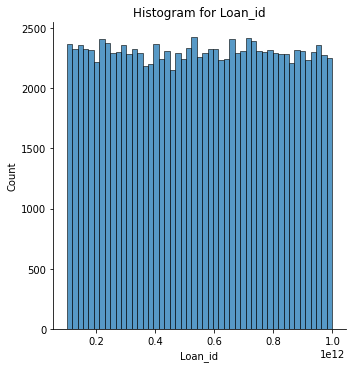

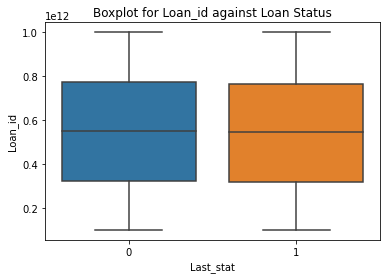

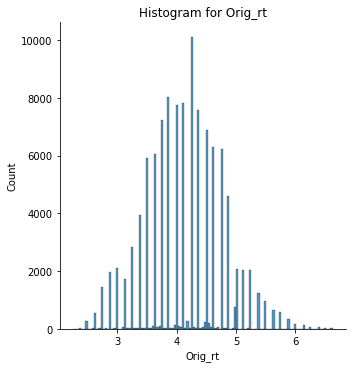

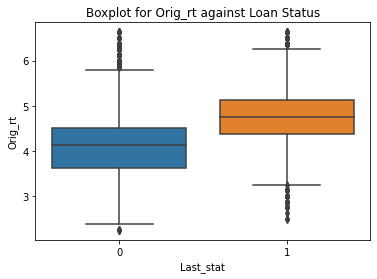

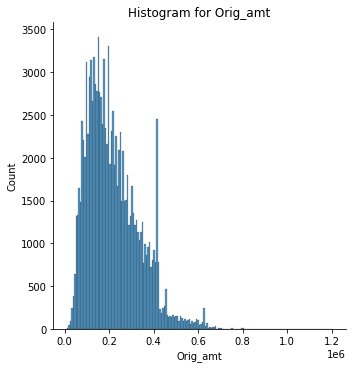

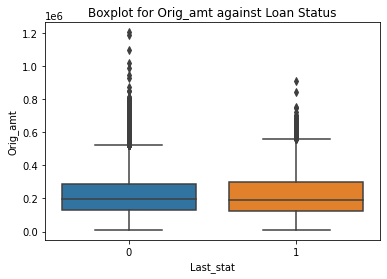

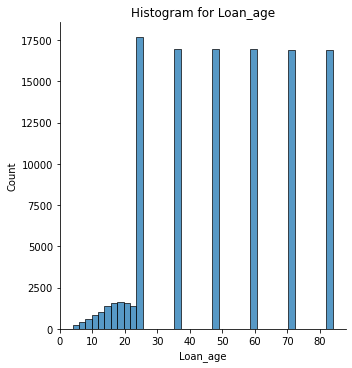

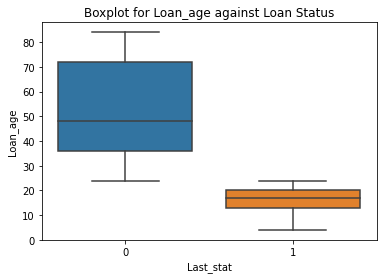

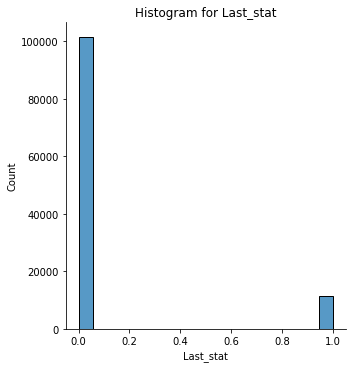

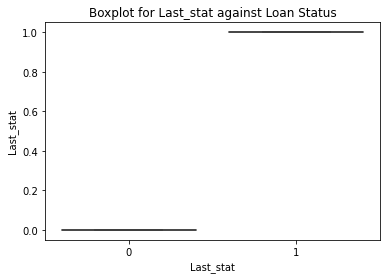

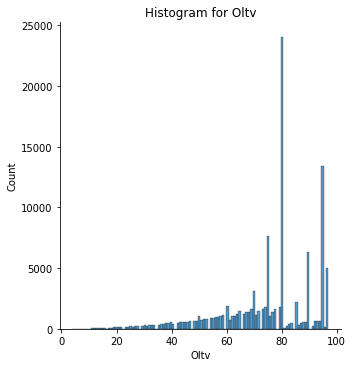

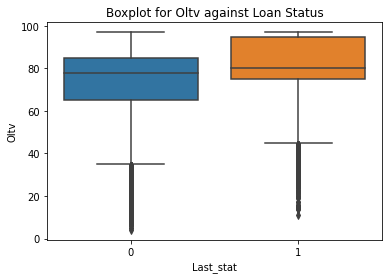

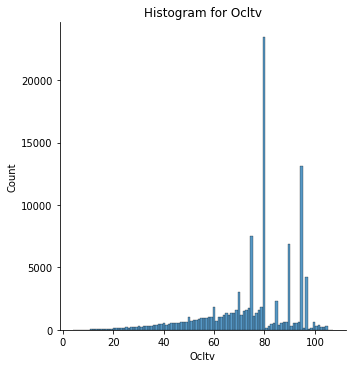

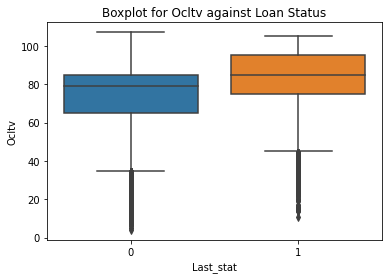

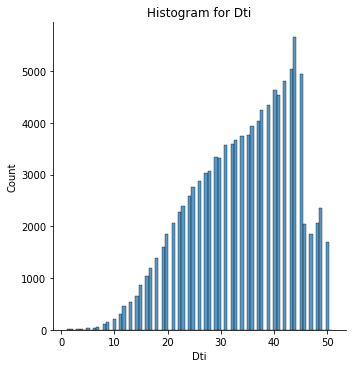

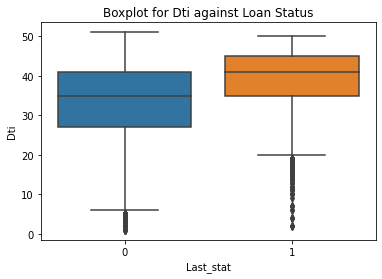

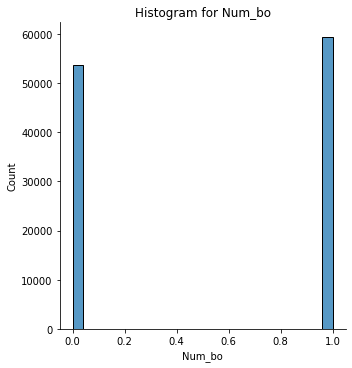

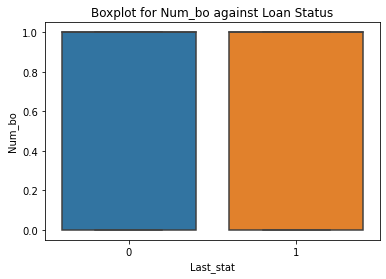

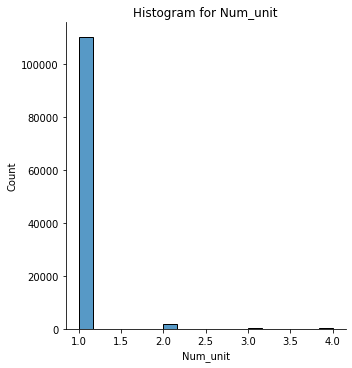

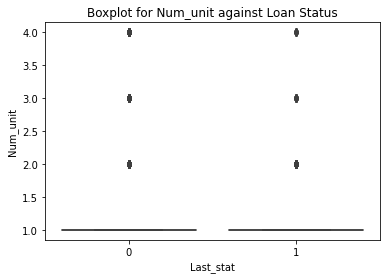

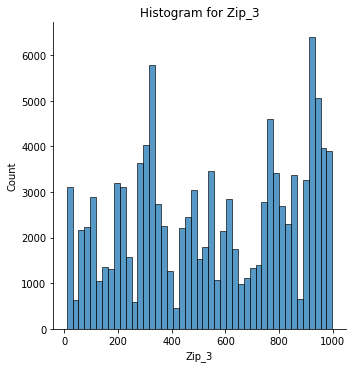

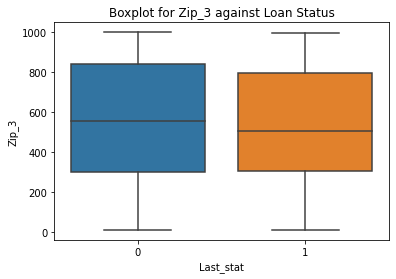

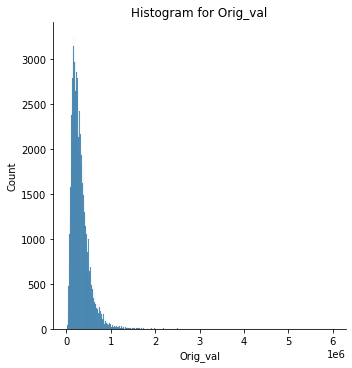

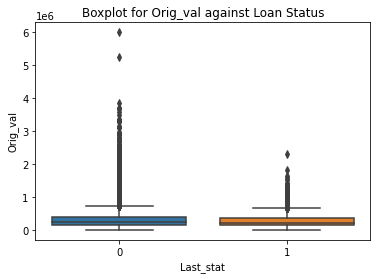

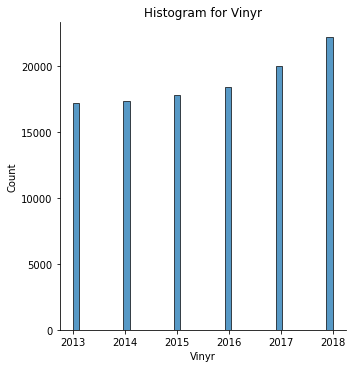

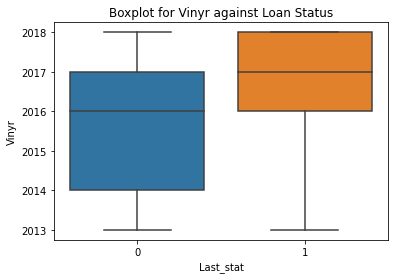

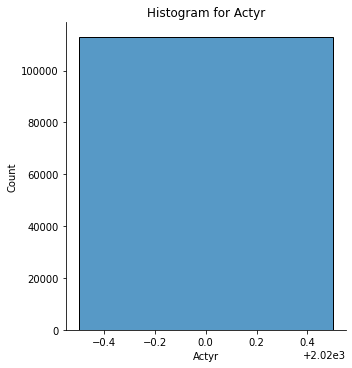

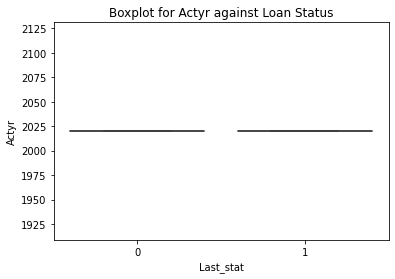

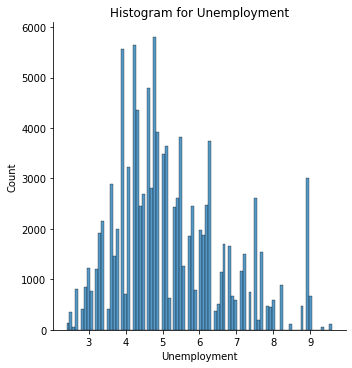

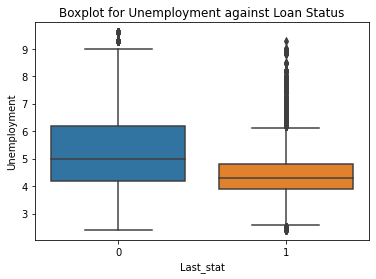

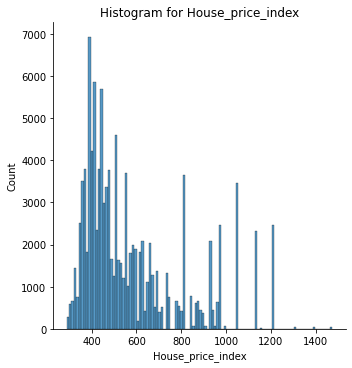

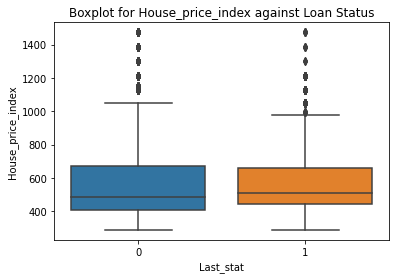

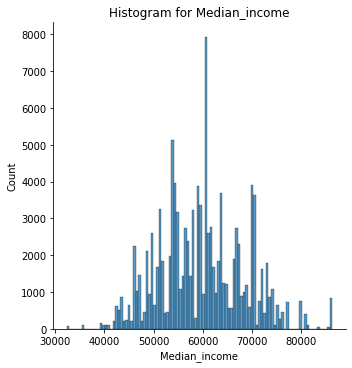

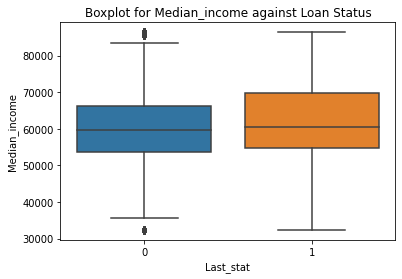

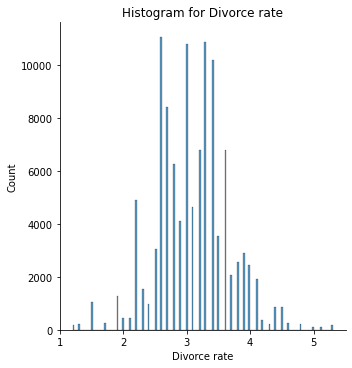

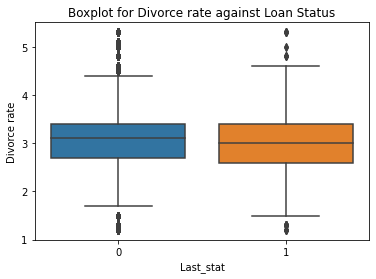

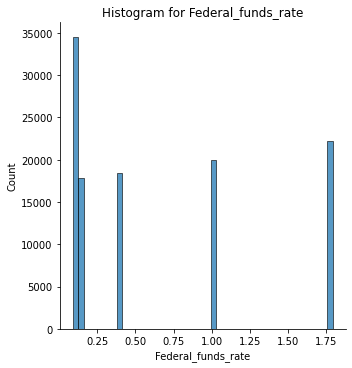

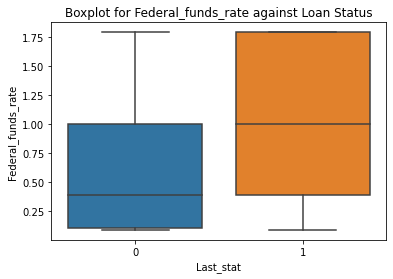

In [87]:
# Original Interest rate
for col in numerical_cols:
  hist_boxplot(df_merge,col)

In [88]:
#Set loans with age>24 to 24
df_merge.loc[df_merge['Loan_age']>24,'Loan_age']=24

In [89]:
# Sample data 
## Class imbalance problem
# Under-sample current loans
def subsample_data(df):
    shuffle = df.sample(frac=1,random_state=SEED)
    shuffle_default = shuffle.loc[shuffle['Last_stat'] == 1]
    shuffle_current = shuffle.loc[shuffle['Last_stat'] == 0].sample(n=len(shuffle_default),random_state=SEED)
    combined = pd.concat([shuffle_current, shuffle_default])
    return combined.sample(frac=1,random_state=SEED)
df_equal=subsample_data(df_merge)

Text(0.5, 1.0, 'Under-sample')

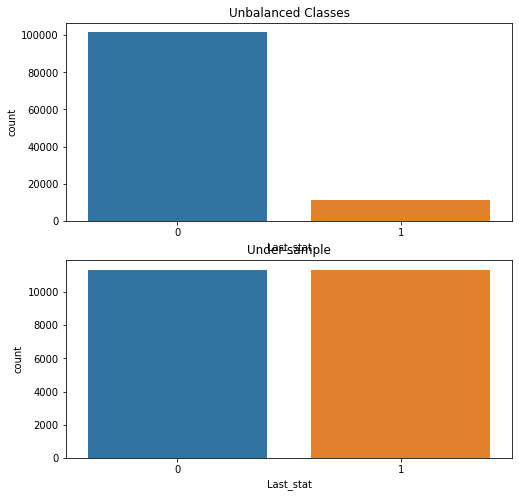

In [90]:
#plot the dataset after the undersampling
plt.figure(figsize=(8, 8))
plt.subplot(211)
sns.countplot('Last_stat', data=df_merge)
plt.title('Unbalanced Classes')
plt.subplot(212)
sns.countplot('Last_stat', data=df_equal)
plt.title('Under-sample')

In [91]:
df_imbalanced=df_merge.copy()
df_balanced=df_equal.copy()

In [92]:
df_imbalanced.Last_stat.value_counts()

0    101556
1     11358
Name: Last_stat, dtype: int64

In [93]:
df_balanced.Last_stat.value_counts()

1    11358
0    11358
Name: Last_stat, dtype: int64

In [94]:
# Subset current and default loans for further preprocessing
features=['Orig_rt', 'Orig_amt','Last_stat','Loan_age',
       'Oltv', 'Ocltv', 'Fthb_flg', 'Dti', 'Num_bo', 'Purpose',
       'Prop_typ', 'Num_unit', 'Occ_stat', 'Orig_val',
        'Ficobkt', 'Unemployment', 'House_price_index',
       'Median_income', 'Divorce rate', 'Federal_funds_rate']
df_imbalanced=df_imbalanced[features]
df_balanced=df_balanced[features]
X_b=df_balanced.drop(columns=['Last_stat'],axis=1)
y_b=df_balanced['Last_stat']

X_imb=df_imbalanced.drop(columns=['Last_stat'],axis=1)
y_imb=df_imbalanced['Last_stat']

In [95]:
y_b.value_counts()

1    11358
0    11358
Name: Last_stat, dtype: int64

In [96]:
#create one hot vectors
categories=['Fthb_flg','Purpose','Prop_typ','Occ_stat','Ficobkt']
X_balance= pd.get_dummies(X_b, columns=categories, drop_first=True)
X_imbalance=pd.get_dummies(X_imb, columns=categories, drop_first=True)

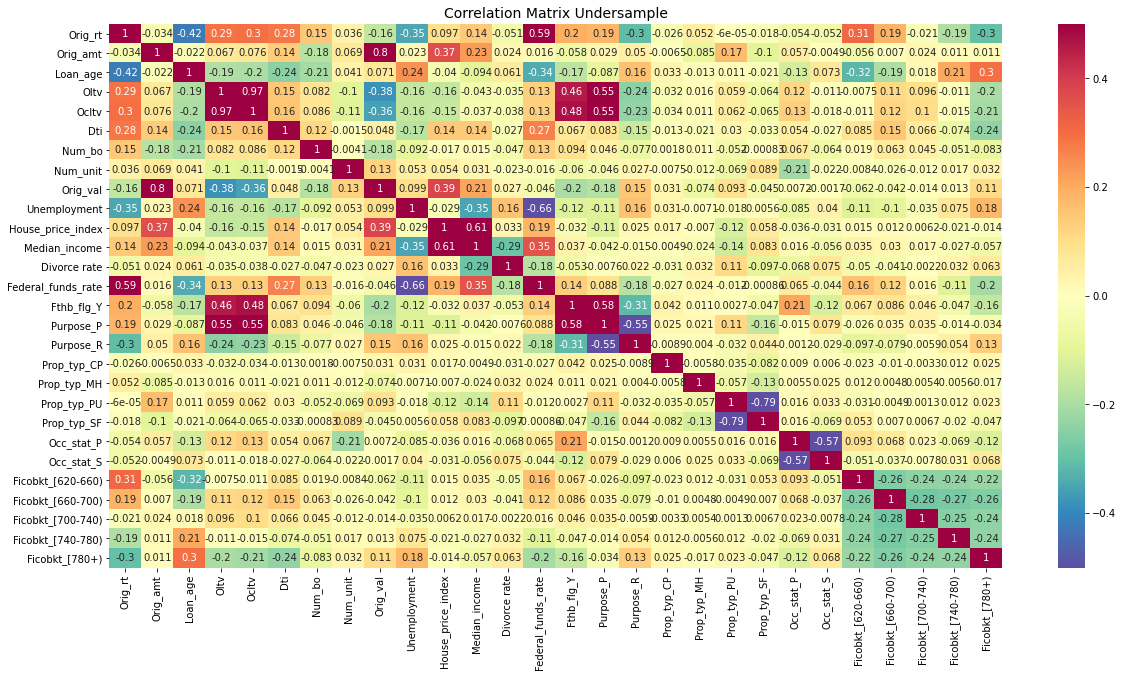

In [97]:
#Correlation Plots for undersampled data
fig, ax = plt.subplots(figsize=(20,10))         
corr_under = X_balance.corr()
sns.heatmap(corr_under, cmap='Spectral_r', annot_kws={'size':10}, ax=ax, vmin = -0.5, vmax = 0.5, annot = True)
ax.set_title("Correlation Matrix Undersample", fontsize=14)
plt.show()

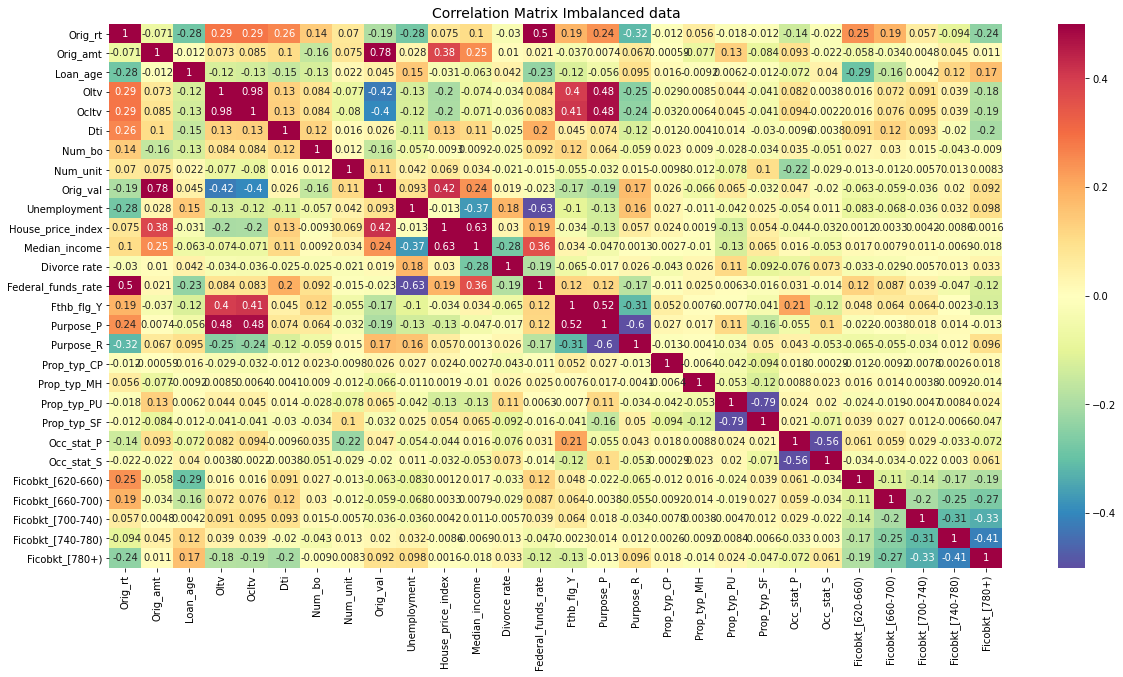

In [98]:
#Correlation Plots for original imbalanced data
fig, ax = plt.subplots(figsize=(20,10))         
corr_under = X_imbalance.corr()
sns.heatmap(corr_under, cmap='Spectral_r', annot_kws={'size':10}, ax=ax, vmin = -0.5, vmax = 0.5, annot = True)
ax.set_title("Correlation Matrix Imbalanced data", fontsize=14)
plt.show()

In [99]:
# Overall loan to value ratio and loan to value ratio are highly correlated so we remove loan to value ratio
X_balance.drop(columns=['Oltv'],inplace=True)
X_imbalance.drop(columns=['Oltv'],inplace=True)

In [100]:
X_balance.to_csv('bal_LR.csv')
X_imbalance.to_csv('imbal_LR.csv')

In [101]:
# Splitting data into train, validation and test sets
X_train_imbalanced, X_test_imbalanced, y_train_imbalanced, y_test_imbalanced=train_test_split(X_imbalance, y_imb,stratify=y_imb,test_size=0.25, random_state=SEED)
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced=train_test_split(X_balance, y_b, test_size=0.25,random_state=SEED)

#Make copies
X_train_imb=X_train_imbalanced.copy()
X_test_imb=X_test_imbalanced.copy()

X_train_b=X_train_balanced.copy()
X_test_b=X_test_balanced.copy()

X_train_imb.drop(columns=['Loan_age'],axis=1,inplace=True)
X_test_imb.drop(columns=['Loan_age'],axis=1,inplace=True)
X_train_b.drop(columns=['Loan_age'],axis=1,inplace=True)
X_test_b.drop(columns=['Loan_age'],axis=1,inplace=True)

In [102]:
# Create a function for all algorithms
def GetBasedModel():
  basedModels = []
  basedModels.append(('LR'   , LogisticRegression()))
  basedModels.append(('LDA'  , LinearDiscriminantAnalysis()))
  basedModels.append(('QDA'  , QuadraticDiscriminantAnalysis()))
  basedModels.append(('KNN'  , KNeighborsClassifier()))
  basedModels.append(('CART' , DecisionTreeClassifier()))
  basedModels.append(('NB'   , GaussianNB()))
  #basedModels.append(('SVM'  , SVC(probability=True)))
  basedModels.append(('AB'   , AdaBoostClassifier()))
  basedModels.append(('GBM'  , GradientBoostingClassifier()))
  basedModels.append(('RF'   , RandomForestClassifier()))
  basedModels.append(('ET'   , ExtraTreesClassifier()))

  return basedModels


In [103]:
  # Evaluation metric definition
def BasedLine2(X_train, y_train,models):
    # Test options and evaluation metric
    num_folds = 10

    accuracy = []
    precision=[]
    recall=[]
    f1=[]
    names = []
    for name, model in models:
        kfold = StratifiedKFold(n_splits=num_folds,random_state=SEED)
        cv_accuracy = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
        cv_precision = cross_val_score(model, X_train, y_train, cv=kfold, scoring='precision')
        cv_recall = cross_val_score(model, X_train, y_train, cv=kfold, scoring='recall')
        cv_f1 = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')
        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        names.append(name)
        msg = "%s: %f (%f) %f (%f) %f (%f) %f (%f)" % (name, cv_accuracy.mean(), cv_accuracy.std(),cv_precision.mean(),cv_precision.std(),
                                                       cv_recall.mean(),cv_recall.std(),cv_f1.mean(),cv_f1.std())
        print(msg)
        
    return names, accuracy, precision, recall ,f1

In [104]:
# Present results as a dataframe
def ScoreDataFrame(names,acc,pre,rec,f1):
    def floatingDecimals(f_val, dec=3):
        prc = "{:."+str(dec)+"f}" 
    
        return float(prc.format(f_val))

    accuracy = []
    precision=[]
    recall=[]
    f_score=[]
    for a in acc:
        accuracy.append(floatingDecimals(a.mean(),4))
    for p in pre:
        precision.append(floatingDecimals(p.mean(),4))
    for r in rec:
        recall.append(floatingDecimals(r.mean(),4))
    for f in f1:
        f_score.append(floatingDecimals(f.mean(),4))

    a = {'Model':names, 'Accuracy':accuracy,'Precision':precision,'Recall':recall,'F1':f_score}
    scoreDataFrame = pd.DataFrame.from_dict(a, orient='index')
    scoreDataFrame = scoreDataFrame.transpose()  
    return scoreDataFrame

In [105]:
# Cross validation results for balanced data
models_bal = GetBasedModel()
names,acc,pre,rec,f1 = BasedLine2(X_train_b,y_train_balanced,models_bal)
balanced_cross_val_df = ScoreDataFrame(names,acc,pre,rec,f1)
balanced_cross_val_df 



LR: 0.624818 (0.031877) 0.602466 (0.031814) 0.749530 (0.022019) 0.667226 (0.018495)
LDA: 0.831719 (0.009842) 0.813236 (0.011875) 0.862161 (0.013521) 0.836900 (0.009482)
QDA: 0.500382 (0.000992) 0.791667 (0.314576) 0.002813 (0.001754) 0.005601 (0.003484)
KNN: 0.609672 (0.008213) 0.611188 (0.008796) 0.606538 (0.011974) 0.608794 (0.008655)
CART: 0.775370 (0.010427) 0.782139 (0.014276) 0.772851 (0.012816) 0.774783 (0.010299)
NB: 0.655807 (0.007158) 0.621555 (0.007064) 0.800046 (0.010473) 0.699530 (0.005166)
AB: 0.837294 (0.011742) 0.831858 (0.012341) 0.846223 (0.014193) 0.838934 (0.011779)
GBM: 0.841874 (0.010123) 0.825586 (0.011841) 0.867555 (0.012399) 0.845991 (0.009780)
RF: 0.843634 (0.012277) 0.831852 (0.016850) 0.865562 (0.011566) 0.845077 (0.015184)
ET: 0.837530 (0.012896) 0.826010 (0.014703) 0.855717 (0.009633) 0.841327 (0.010544)


,Model,Accuracy,Precision,Recall,F1
0,LR,0.6248,0.6025,0.7495,0.6672
1,LDA,0.8317,0.8132,0.8622,0.8369
2,QDA,0.5004,0.7917,0.0028,0.0056
3,KNN,0.6097,0.6112,0.6065,0.6088
4,CART,0.7754,0.7821,0.7729,0.7748
5,NB,0.6558,0.6216,0.8,0.6995
6,AB,0.8373,0.8319,0.8462,0.8389
7,GBM,0.8419,0.8256,0.8676,0.846
8,RF,0.8436,0.8319,0.8656,0.8451
9,ET,0.8375,0.826,0.8557,0.8413


In [106]:
# Cross validation results for imbalanced data
models_imb = GetBasedModel()
names_imb,acc_imb,pre_imb,rec_imb,f1_imb = BasedLine2(X_train_imb,y_train_imbalanced,models_imb)
imbalanced_cross_val_df = ScoreDataFrame(names_imb,acc_imb,pre_imb,rec_imb,f1_imb)
imbalanced_cross_val_df 

LR: 0.899415 (0.000045) 0.000000 (0.000000) 0.000000 (0.000000) 0.000000 (0.000000)
LDA: 0.901517 (0.003216) 0.512739 (0.019091) 0.425688 (0.014730) 0.465129 (0.016074)
QDA: 0.819071 (0.007925) 0.331035 (0.011327) 0.779997 (0.015252) 0.464668 (0.011711)
KNN: 0.897514 (0.001548) 0.472657 (0.022609) 0.161778 (0.010479) 0.240910 (0.013394)
CART: 0.881644 (0.002247) 0.413933 (0.010564) 0.445883 (0.010521) 0.429638 (0.008348)
NB: 0.898731 (0.000816) 0.421386 (0.106875) 0.017257 (0.003966) 0.033135 (0.007586)
AB: 0.911000 (0.002397) 0.592107 (0.019910) 0.371332 (0.013611) 0.456281 (0.014108)
GBM: 0.914129 (0.002659) 0.624990 (0.024649) 0.366754 (0.009404) 0.462197 (0.013637)
RF: 0.918687 (0.001905) 0.671787 (0.015022) 0.371802 (0.016552) 0.474180 (0.015024)
ET: 0.915286 (0.001292) 0.629302 (0.012438) 0.380138 (0.020895) 0.473227 (0.019737)


,Model,Accuracy,Precision,Recall,F1
0,LR,0.8994,0,0,0
1,LDA,0.9015,0.5127,0.4257,0.4651
2,QDA,0.8191,0.331,0.78,0.4647
3,KNN,0.8975,0.4727,0.1618,0.2409
4,CART,0.8816,0.4139,0.4459,0.4296
5,NB,0.8987,0.4214,0.0173,0.0331
6,AB,0.911,0.5921,0.3713,0.4563
7,GBM,0.9141,0.625,0.3668,0.4622
8,RF,0.9187,0.6718,0.3718,0.4742
9,ET,0.9153,0.6293,0.3801,0.4732


In [107]:
y_train_imbalanced.value_counts()

0    76167
1     8518
Name: Last_stat, dtype: int64

In [108]:
# Transformation of variables
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


def GetScaledModel(nameOfScaler):
    
    if nameOfScaler == 'standard':
        scaler = StandardScaler()
    elif nameOfScaler =='minmax':
        scaler = MinMaxScaler()

    pipelines = []
    pipelines.append((nameOfScaler+'LR'  , Pipeline([('Scaler', scaler),('LR'  , LogisticRegression())])))
    pipelines.append((nameOfScaler+'LDA' , Pipeline([('Scaler', scaler),('LDA' , LinearDiscriminantAnalysis())])))
    pipelines.append((nameOfScaler+'QDA' , Pipeline([('Scaler', scaler),('QDA' , QuadraticDiscriminantAnalysis())])))
    pipelines.append((nameOfScaler+'KNN' , Pipeline([('Scaler', scaler),('KNN' , KNeighborsClassifier())])))
    pipelines.append((nameOfScaler+'CART', Pipeline([('Scaler', scaler),('CART', DecisionTreeClassifier())])))
    pipelines.append((nameOfScaler+'NB'  , Pipeline([('Scaler', scaler),('NB'  , GaussianNB())])))
    #pipelines.append((nameOfScaler+'SVM' , Pipeline([('Scaler', scaler),('SVM' , SVC())])))
    pipelines.append((nameOfScaler+'AB'  , Pipeline([('Scaler', scaler),('AB'  , AdaBoostClassifier())])  ))
    pipelines.append((nameOfScaler+'GBM' , Pipeline([('Scaler', scaler),('GMB' , GradientBoostingClassifier())])  ))
    pipelines.append((nameOfScaler+'RF'  , Pipeline([('Scaler', scaler),('RF'  , RandomForestClassifier())])  ))
    pipelines.append((nameOfScaler+'ET'  , Pipeline([('Scaler', scaler),('ET'  , ExtraTreesClassifier())])  ))


    return pipelines 

In [109]:
# standard scaler (normal distribution)
models = GetScaledModel('standard')
names,acc,pre,rec,f1  = BasedLine2(X_train_b,y_train_balanced,models)
#PlotBoxR().PlotResult(names,results)
scaledScoreStandard_bal_s = ScoreDataFrame(names,acc,pre,rec,f1)
compareModels_bal_s = pd.concat([balanced_cross_val_df ,
                           scaledScoreStandard_bal_s ], axis=1)
compareModels_bal_s



standardLR: 0.833656 (0.010911) 0.824084 (0.013214) 0.849385 (0.015988) 0.836429 (0.010834)
standardLDA: 0.831719 (0.009842) 0.813236 (0.011875) 0.862161 (0.013521) 0.836900 (0.009482)
standardQDA: 0.499325 (0.000295) 0.200000 (0.400000) 0.000234 (0.000469) 0.000468 (0.000937)
standardKNN: 0.818689 (0.012865) 0.798839 (0.012122) 0.852669 (0.013232) 0.824872 (0.012497)
standardCART: 0.776075 (0.011737) 0.780294 (0.012823) 0.772028 (0.018420) 0.776106 (0.014036)
standardNB: 0.797029 (0.015091) 0.753218 (0.014625) 0.884784 (0.014863) 0.813668 (0.013465)
standardAB: 0.837294 (0.011742) 0.831858 (0.012341) 0.846223 (0.014193) 0.838934 (0.011779)
standardGBM: 0.841815 (0.010130) 0.825586 (0.011841) 0.867555 (0.012399) 0.845991 (0.009780)
standardRF: 0.845101 (0.014041) 0.832654 (0.015236) 0.863335 (0.012247) 0.847826 (0.014241)
standardET: 0.838058 (0.013044) 0.826811 (0.016325) 0.858177 (0.014334) 0.841393 (0.010622)


,Model,Accuracy,Precision,Recall,F1,Model,Accuracy,Precision,Recall,F1
0,LR,0.6248,0.6025,0.7495,0.6672,standardLR,0.8337,0.8241,0.8494,0.8364
1,LDA,0.8317,0.8132,0.8622,0.8369,standardLDA,0.8317,0.8132,0.8622,0.8369
2,QDA,0.5004,0.7917,0.0028,0.0056,standardQDA,0.4993,0.2,0.0002,0.0005
3,KNN,0.6097,0.6112,0.6065,0.6088,standardKNN,0.8187,0.7988,0.8527,0.8249
4,CART,0.7754,0.7821,0.7729,0.7748,standardCART,0.7761,0.7803,0.772,0.7761
5,NB,0.6558,0.6216,0.8,0.6995,standardNB,0.797,0.7532,0.8848,0.8137
6,AB,0.8373,0.8319,0.8462,0.8389,standardAB,0.8373,0.8319,0.8462,0.8389
7,GBM,0.8419,0.8256,0.8676,0.846,standardGBM,0.8418,0.8256,0.8676,0.846
8,RF,0.8436,0.8319,0.8656,0.8451,standardRF,0.8451,0.8327,0.8633,0.8478
9,ET,0.8375,0.826,0.8557,0.8413,standardET,0.8381,0.8268,0.8582,0.8414


In [110]:
# Scale test data
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import plot_confusion_matrix

model = RandomForestClassifier(n_estimators=100, random_state=SEED)
def predict_test(model,X_train,y_train,X_test,y_test,name):
  # Bundle preprocessing and modeling code in a pipeline
  my_pipeline = Pipeline(steps=[('Scaler', StandardScaler()),
                              ('model', model)
                          ])
  results=[] 
  # Preprocessing of training data, fit model 
  my_pipeline.fit(X_train, y_train)
  # Preprocessing of validation data, get predictions
  preds = my_pipeline.predict(X_test)
  acc=accuracy_score(y_test, preds)
  pre=precision_score(y_test, preds)
  re=recall_score(y_test, preds)
  f1=f1_score(y_test, preds)
  results.append((acc,pre,re,f1))
  plot_confusion_matrix(my_pipeline, X_test, y_test)
  plt.title(" {} on test data".format(name) )
  plt.show()
  return results



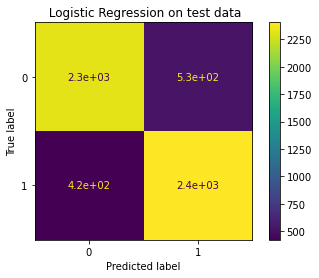

[(0.8328931149850326,
  0.8199795431299012,
  0.8510261854210899,
  0.835214446952596)]

In [111]:
#Logistic Regression
modelLR = LogisticRegression()
predict_test(modelLR,X_train_b,y_train_balanced,X_test_b,y_test_balanced, "Logistic Regression")

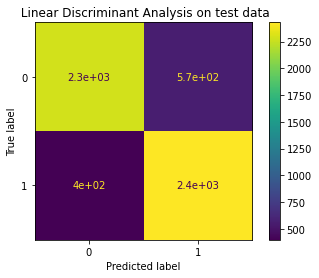

[(0.8304278922345484,
  0.8110183639398998,
  0.859518754423213,
  0.8345645078165264)]

In [112]:
#LDA
modelLDA = LinearDiscriminantAnalysis()
predict_test(modelLDA,X_train_b,y_train_balanced,X_test_b,y_test_balanced,"Linear Discriminant Analysis")

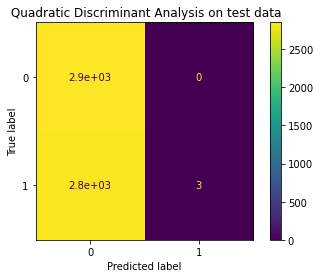

[(0.502905441098785, 1.0, 0.0010615711252653928, 0.0021208907741251323)]

In [113]:
#QDA
modelQDA = QuadraticDiscriminantAnalysis()
predict_test(modelQDA,X_train_b,y_train_balanced,X_test_b,y_test_balanced,"Quadratic Discriminant Analysis")

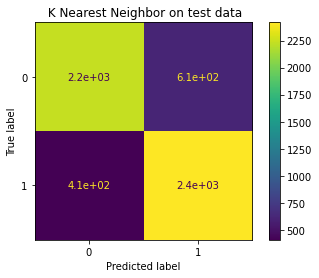

[(0.8205670012326114,
  0.7980864401187727,
  0.8559801840056617,
  0.8260201468328495)]

In [114]:
#KNN
modelKNN = KNeighborsClassifier()
predict_test(modelKNN,X_train_b,y_train_balanced,X_test_b,y_test_balanced, "K Nearest Neighbor")

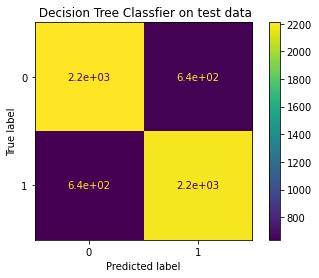

[(0.7747842930093326,
  0.7730321214260502,
  0.7749469214437368,
  0.7739883371620428)]

In [115]:
#CART
modelDT = DecisionTreeClassifier()
predict_test(modelDT,X_train_b,y_train_balanced,X_test_b,y_test_balanced,"Decision Tree Classfier")

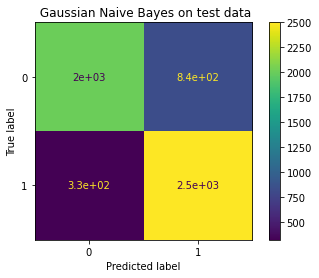

[(0.7950343370311674,
  0.7489514679448772,
  0.8846426043878273,
  0.8111615833874107)]

In [116]:
#NB
modelNB = GaussianNB()
predict_test(modelNB,X_train_b,y_train_balanced,X_test_b,y_test_balanced,"Gaussian Naive Bayes")

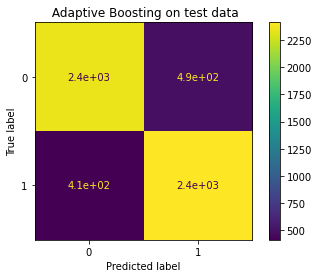

[(0.8404648705758055,
  0.8301237964236589,
  0.854210898796886,
  0.8419951168468782)]

In [117]:
#AB
modelAB = AdaBoostClassifier()
predict_test(modelAB,X_train_b,y_train_balanced,X_test_b,y_test_balanced,"Adaptive Boosting")

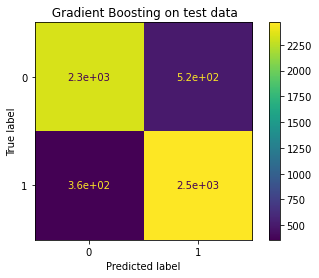

[(0.8460996654340552,
  0.8272971160295104,
  0.872965322009908,
  0.849517906336088)]

In [118]:
#GBM
modelGBM = GradientBoostingClassifier()
predict_test(modelGBM,X_train_b,y_train_balanced,X_test_b,y_test_balanced,"Gradient Boosting")

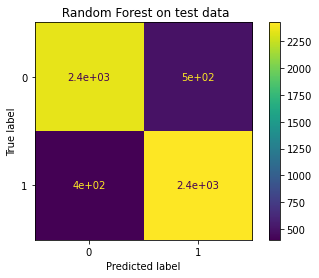

[(0.8413453072724071,
  0.8288349846258968,
  0.8584571832979476,
  0.8433860594472449)]

In [119]:
# RF
modelRF = RandomForestClassifier(n_estimators=100, random_state=SEED)
predict_test(modelRF,X_train_b,y_train_balanced,X_test_b,y_test_balanced,"Random Forest")

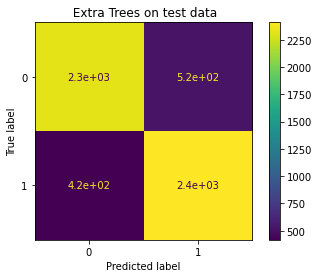

[(0.8344779010389153,
  0.8216234652114598,
  0.8524416135881104,
  0.8367488711358111)]

In [120]:
#ET
modelET = ExtraTreesClassifier()
predict_test(modelET,X_train_b,y_train_balanced,X_test_b,y_test_balanced,"Extra Trees")


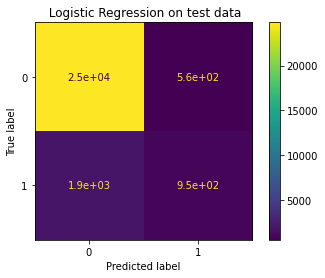

[(0.9129618477452265,
  0.6265697290152016,
  0.33380281690140845,
  0.43556168159889735)]

In [121]:
#Imbalanced data
#Logistic Regression
modelLR = LogisticRegression()
predict_test(modelLR,X_train_imb,y_train_imbalanced,X_test_imb,y_test_imbalanced, "Logistic Regression")


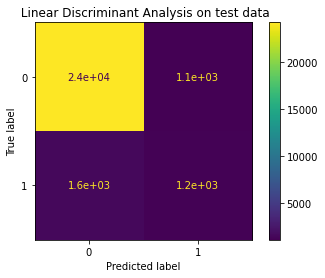

[(0.9039640086435935,
  0.5272266779231743,
  0.4397887323943662,
  0.47955461700902285)]

In [122]:
#LDA
modelLDA = LinearDiscriminantAnalysis()
predict_test(modelLDA,X_train_imb,y_train_imbalanced,X_test_imb,y_test_imbalanced,"Linear Discriminant Analysis")


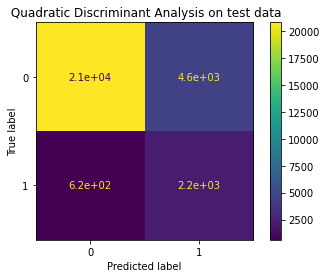

[(0.8165716107548975,
  0.32763196697139485,
  0.782394366197183,
  0.46185824152982746)]

In [123]:
#QDA
modelQDA = QuadraticDiscriminantAnalysis()
predict_test(modelQDA,X_train_imb,y_train_imbalanced,X_test_imb,y_test_imbalanced,"Quadratic Discriminant Analysis")



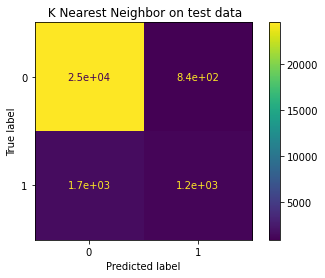

[(0.9108009493782989,
  0.5800995024875621,
  0.41056338028169015,
  0.4808247422680412)]

In [124]:
#KNN
modelKNN = KNeighborsClassifier()
predict_test(modelKNN,X_train_imb,y_train_imbalanced,X_test_imb,y_test_imbalanced, "K Nearest Neighbor")


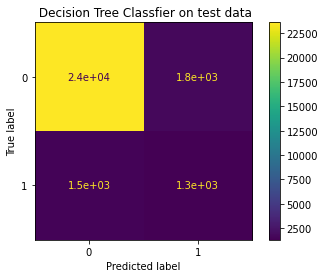

[(0.88302809167877, 0.4253875968992248, 0.4637323943661972, 0.443733153638814)]

In [125]:
#CART
modelDT = DecisionTreeClassifier()
predict_test(modelDT,X_train_imb,y_train_imbalanced,X_test_imb,y_test_imbalanced,"Decision Tree Classfier")

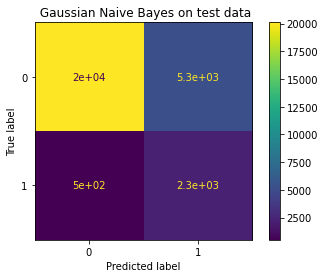

[(0.7949980516490134,
  0.30660191626197664,
  0.8225352112676056,
  0.44669662491634005)]

In [126]:
#NB
modelNB = GaussianNB()
predict_test(modelNB,X_train_imb,y_train_imbalanced,X_test_imb,y_test_imbalanced,"Gaussian Naive Bayes")


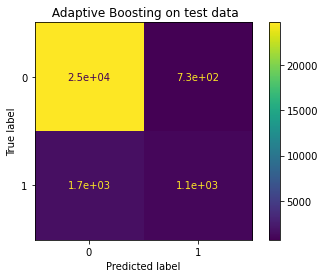

[(0.913032696872011,
  0.6043360433604336,
  0.3926056338028169,
  0.47598719316969046)]

In [127]:
#AB
modelAB = AdaBoostClassifier()
predict_test(modelAB,X_train_imb,y_train_imbalanced,X_test_imb,y_test_imbalanced,"Adaptive Boosting")


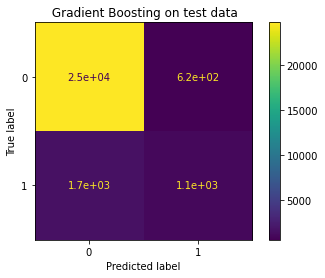

[(0.9165751532112367,
  0.640742890307603,
  0.38873239436619716,
  0.48389217619986846)]

In [128]:
#GBM
modelGBM = GradientBoostingClassifier()
predict_test(modelGBM,X_train_imb,y_train_imbalanced,X_test_imb,y_test_imbalanced,"Gradient Boosting")


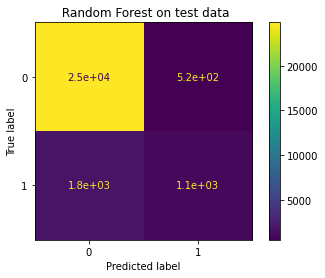

[(0.9190902972120869,
  0.6746231155778895,
  0.37816901408450704,
  0.48465703971119134)]

In [129]:
# RF
modelRF = RandomForestClassifier(n_estimators=100, random_state=SEED)
predict_test(modelRF,X_train_imb,y_train_imbalanced,X_test_imb,y_test_imbalanced,"Random Forest")


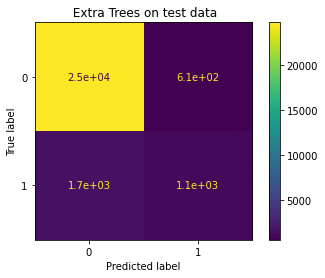

[(0.9178150129299656,
  0.6494252873563219,
  0.397887323943662,
  0.49344978165938874)]

In [130]:
#ET
modelET = ExtraTreesClassifier()
predict_test(modelET,X_train_imb,y_train_imbalanced,X_test_imb,y_test_imbalanced,"Extra Trees")

In [131]:
#Prepare data for Survival Analysis
X_surv_train_bal=X_train_balanced.copy()
X_surv_test_bal=X_test_balanced.copy()
Y_surv_train_bal=y_train_balanced.copy()
Y_surv_test_bal=y_test_balanced.copy()
T_train_bal=X_surv_train_bal['Loan_age']
T_test_bal=X_surv_test_bal['Loan_age']

X_surv_train_imbal=X_train_imbalanced.copy()
X_surv_test_imbal=X_test_imbalanced.copy()
Y_surv_train_imbal=y_train_imbalanced.copy()
Y_surv_test_imbal=y_test_imbalanced.copy()
T_train_imbal=X_surv_train_imbal['Loan_age']
T_test_imbal=X_surv_test_imbal['Loan_age']

In [133]:
from pysurvival.models.multi_task import LinearMultiTaskModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score

# Multi task Logistic regression
#### 4 - Creating an instance of the Linear MTLR model and fitting the data.
# Building the model
l_mtlr_bal = LinearMultiTaskModel(bins=50)
l_mtlr_bal.fit(X_surv_train_bal, T_train_bal, Y_surv_train_bal, lr=1e-3, init_method='orthogonal')



LinearMultiTaskModel

C-index: 0.97


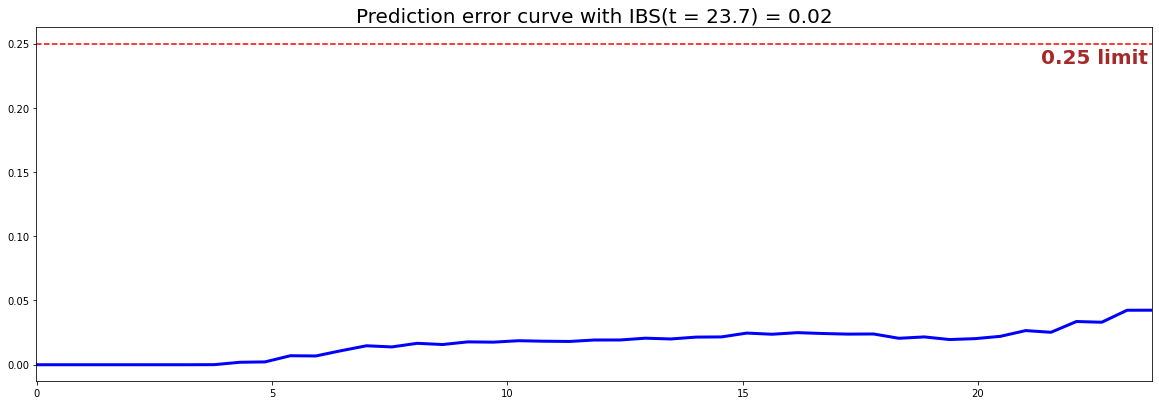

IBS: 0.02


In [134]:
# Chaeck performance on test set
#Model Performances
from pysurvival.utils.metrics import concordance_index
c_index_bal = concordance_index(l_mtlr_bal, X_surv_test_bal, T_test_bal, Y_surv_test_bal) 
print('C-index: {:.2f}'.format(c_index_bal))

ibs_bal = integrated_brier_score(l_mtlr_bal, X_surv_test_bal, T_test_bal, Y_surv_test_bal, t_max=24,
            figure_size=(20, 6.5) )

print('IBS: {:.2f}'.format(ibs_bal))


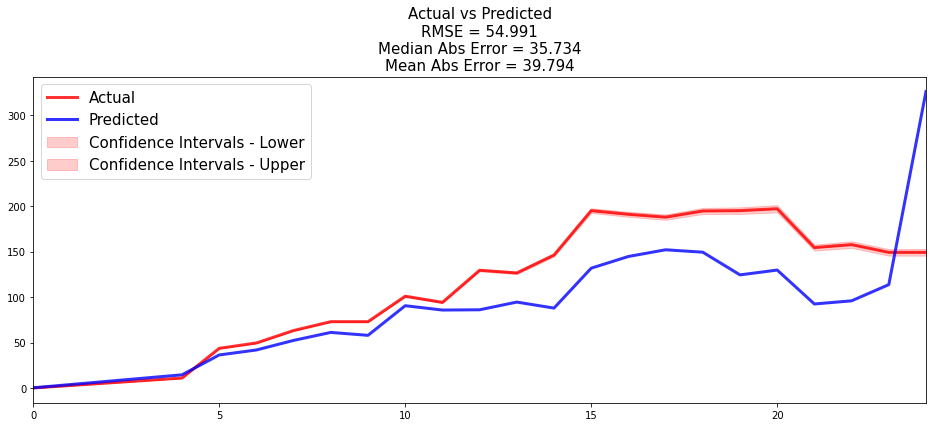

In [135]:
# Overall predictions
from pysurvival.utils.display import compare_to_actual
results_bal = compare_to_actual(l_mtlr_bal, X_surv_test_bal, T_test_bal, Y_surv_test_bal,
                            is_at_risk = False,  figure_size=(16, 6),
                            metrics = ['rmse', 'mean', 'median'])


In [137]:
#Imbalanced data
l_mtlr_imbal = LinearMultiTaskModel(bins=50)
l_mtlr_imbal.fit(X_surv_train_imbal, T_train_imbal, Y_surv_train_imbal, lr=1e-3, init_method='orthogonal')

LinearMultiTaskModel

C-index: 0.93


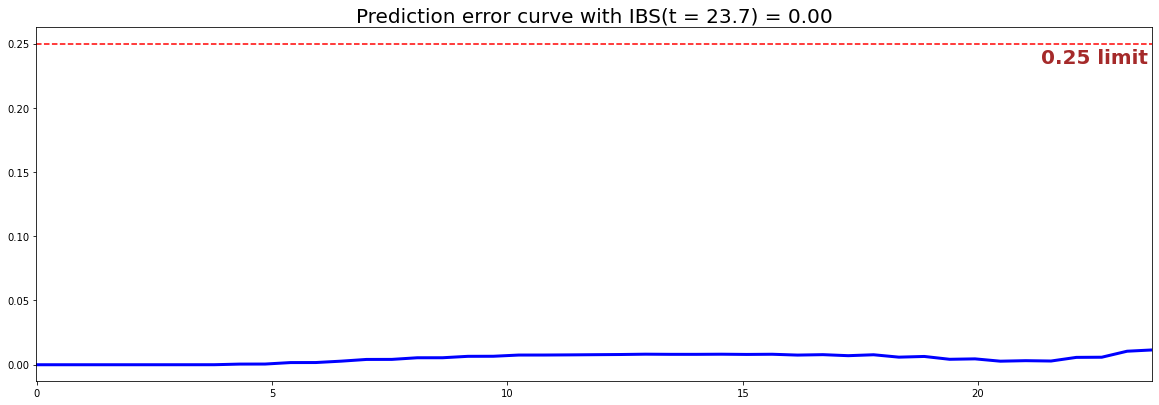

IBS: 0.00


In [138]:
# Chaeck performance on test set
#Model Performances
from pysurvival.utils.metrics import concordance_index
c_index_imbal = concordance_index(l_mtlr_imbal, X_surv_test_imbal, T_test_imbal, Y_surv_test_imbal) 
print('C-index: {:.2f}'.format(c_index_imbal))

ibs_imbal = integrated_brier_score(l_mtlr_imbal, X_surv_test_imbal, T_test_imbal, Y_surv_test_imbal,
            figure_size=(20, 6.5), )
print('IBS: {:.2f}'.format(ibs_imbal))

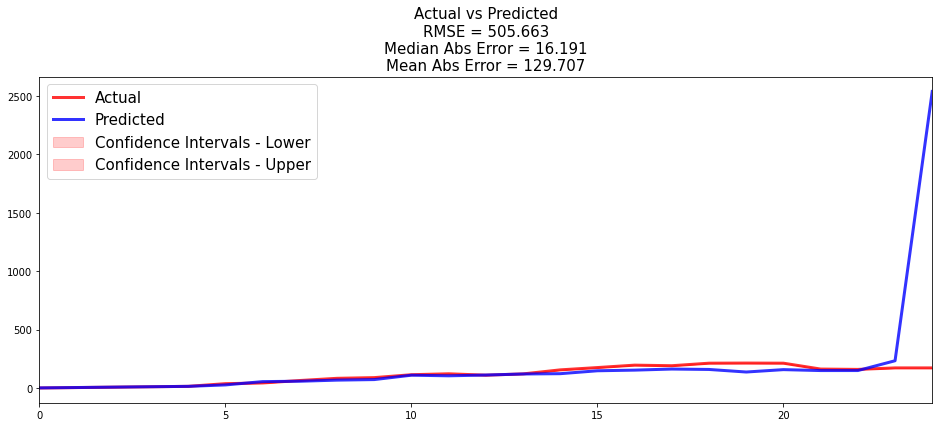

In [139]:
# Overall predictions
from pysurvival.utils.display import compare_to_actual
results_imbal = compare_to_actual(l_mtlr_imbal, X_surv_test_imbal, T_test_imbal, Y_surv_test_imbal,
                            is_at_risk = False,  figure_size=(16, 6),
                            metrics = ['rmse', 'mean', 'median'])
